# Task 3: Predictive Modeling for Banking Trends with Pyspark

## **Import Libraries**

In [ ]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("PySpark").getOrCreate()

## **Data Loading:**

Loading data is the first step in any data analysis process. PySpark supports various data sources such as CSV files, Parquet files, and databases. Here's an example of loading data from a CSV file:

In [ ]:
# Load data from a CSV file
bank_df = spark.read.csv("bank.csv", header=True, inferSchema=True)

## **Data Exploration:**

Data exploration involves understanding the structure and content of the data. PySpark provides methods like show(), head(), and describe() for this purpose:

In [ ]:
# Display the first few rows of the DataFrame
bank_df.show()

+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|          job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|   unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|     services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35|   management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|   management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|  blue-collar|married|secondary|     no|      0|    yes|  no| unknown| 

In [ ]:
# Display specific number of rows
bank_df.head(5)

[Row(age=30, job='unemployed', marital='married', education='primary', default='no', balance=1787, housing='no', loan='no', contact='cellular', day=19, month='oct', duration=79, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no'),
 Row(age=33, job='services', marital='married', education='secondary', default='no', balance=4789, housing='yes', loan='yes', contact='cellular', day=11, month='may', duration=220, campaign=1, pdays=339, previous=4, poutcome='failure', y='no'),
 Row(age=35, job='management', marital='single', education='tertiary', default='no', balance=1350, housing='yes', loan='no', contact='cellular', day=16, month='apr', duration=185, campaign=1, pdays=330, previous=1, poutcome='failure', y='no'),
 Row(age=30, job='management', marital='married', education='tertiary', default='no', balance=1476, housing='yes', loan='yes', contact='unknown', day=3, month='jun', duration=199, campaign=4, pdays=-1, previous=0, poutcome='unknown', y='no'),
 Row(age=59, job='blue-coll

In [ ]:
# Generate summary statistics of the DataFrame
bank_df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|summary|               age|    job| marital|education|default|           balance|housing|loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|   y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|  count|              4521|   4521|    4521|     4521|   4521|              4521|   4521|4521|    4521|              4521| 4521|              4521|              4521|              4521|              4521|    4521|4521|
|   mean| 41.17009511170095|   NULL|    NULL|     NULL|   NULL|1422.6578190665782|   NULL|NULL|    NULL|15.9152842291528

## **Data Preprocessing**

let's proceed with the data preprocessing steps:

1. Handle Missing Values:

To handle missing values in the dataset, we'll need to identify columns with missing values and decide on an appropriate strategy to handle them. Common strategies include imputation (replacing missing values with a statistical measure such as mean, median, or mode) or dropping rows or columns with missing values depending on the context.

2. Handle Outliers:

Outliers can be handled by either removing them or transforming them to mitigate their impact on the model. Techniques like winsorization (replacing extreme values with less extreme values) or using robust estimators can be employed.

3. Convert Categorical Variables:

Categorical variables need to be converted into numerical format for the machine learning model to process them. This can be done using techniques like StringIndexer (assigning a unique numerical index to each category) or OneHotEncoder (creating binary columns for each category).

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# 1. Handle Missing Values
# Identify columns with missing values
missing_cols = [col_name for col_name in bank_df.columns if bank_df.filter(col(col_name).isNull()).count() > 0]

In [ ]:
missing_cols

[]

In [ ]:
# 2. Handle Outliers in balance column
bank_df = bank_df.filter((col("balance") > 0) & (col("balance") < 72000))
bank_df.show()

+---+-------------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|          job| marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|   unemployed| married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|     services| married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35|   management|  single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|   management| married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 35|   management|  single| tertiary|     no|    747|     no|  no|ce

In [ ]:
# 3. Convert Categorical Variables
# List of categorical columns
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

# StringIndexer stages for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_columns]



# Combine all stages into a single list
stages = indexers

# Create and fit the pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(bank_df)
encoded_df = pipeline_model.transform(bank_df)

# Display the processed DataFrame
encoded_df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+
|age|       job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+
| 30|unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|      8.0|          0.0|            2.0|          0.0|          1.0|       0.0|          0.0|        8.0|           0.0|
| 33

## **Feature Engineering and Data Transformation:**

Define Numeric and Encoded Columns: Define lists of numeric columns and one-hot encoded categorical columns that will be combined into the feature vector.

Combine Feature Columns: Create a list assembler_inputs that contains all the feature columns (both numeric and string indexer).

VectorAssembler: Initialize VectorAssembler with inputCols set to the combined list of feature columns and outputCol set to "features".

Transform DataFrame: Apply the VectorAssembler to the DataFrame to create the "features" column.

Display Processed DataFrame: Display the first few rows of the DataFrame, showing only the "features" column.


In [ ]:
from pyspark.ml.feature import VectorAssembler

# List of numeric columns
numeric_columns = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

# List of string indexer categorical columns (assuming these have been created in preprocessing)
encoded_categorical_columns = [
    "job_index",
    "marital_index",
    "education_index",
    "default_index",
    "housing_index",
    "loan_index",
    "contact_index",
    "month_index",
    "poutcome_index"
]

# Combine all feature columns (numeric and one-hot encoded categorical columns)
assembler_inputs = numeric_columns + encoded_categorical_columns

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Transform the DataFrame
assembled_df = assembler.transform(encoded_df)

# Display the processed DataFrame
assembled_df.select("features").show(5, truncate=False)

+--------------------------------------------------------------------------+
|features                                                                  |
+--------------------------------------------------------------------------+
|[30.0,1787.0,19.0,79.0,1.0,-1.0,0.0,8.0,0.0,2.0,0.0,1.0,0.0,0.0,8.0,0.0]  |
|[33.0,4789.0,11.0,220.0,1.0,339.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0]|
|[35.0,1350.0,16.0,185.0,1.0,330.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0]|
|[30.0,1476.0,3.0,199.0,4.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0]  |
|[35.0,747.0,23.0,141.0,2.0,176.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,6.0,1.0] |
+--------------------------------------------------------------------------+
only showing top 5 rows



## **Model Training and Selection:**


Choose a classification model (e.g., Logistic Regression, Decision Tree Classifier) for predicting the subscription to a term deposit.

Split the data into training and test sets.

Train the model on the training dataset.

Explanation:


Split Data: Split the data into training (80%) and test (20%) sets.

Train Model: Initialize a LogisticRegression model and use TrainValidationSplit for hyperparameter tuning. Train the model on the training dataset.




In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression

import pandas as pd

In [ ]:
# Select features and label column for the final dataset
final_df = assembled_df.select("features","y")

In [ ]:
# StringIndexer for the label column
label_indexer = StringIndexer(inputCol="y", outputCol="label")
final_df = label_indexer.fit(final_df).transform(final_df)

In [ ]:
# Split the data into training and test sets
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

## **Hyperparameter Tuning:**

Perform hyperparameter tuning (using ParamGridBuilder and CrossValidator.)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
# Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001,0.0001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define a CrossValidator for model selection
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # 5-fold cross-validation



In [ ]:
# Train the model with hyperparameter tuning
cv_model = crossval.fit(train_df)

## **Model Evaluation:**


Evaluate the model on the test dataset using appropriate metrics.



Train Accuracy: 0.8846153846153846
Test Accuracy: 0.8977272727272727


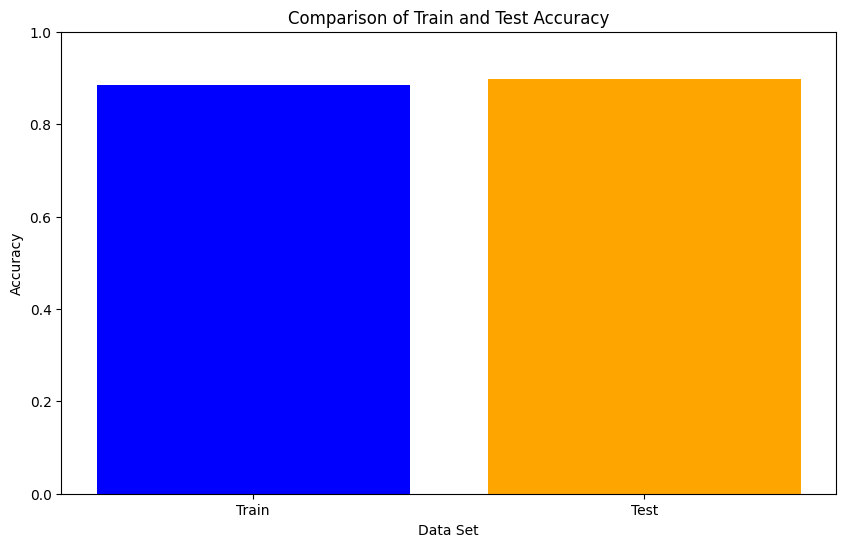

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt

# Make predictions on the training set
train_predictions = cv_model.transform(train_df)

# Evaluate the model on the training set
evaluator = BinaryClassificationEvaluator(labelCol="label")


# Calculate training accuracy
train_accuracy = train_predictions.filter(train_predictions.label == train_predictions.prediction).count() / float(train_df.count())
print(f"Train Accuracy: {train_accuracy}")

# Make predictions on the test set
test_predictions = cv_model.transform(test_df)


# Calculate test accuracy
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_df.count())
print(f"Test Accuracy: {test_accuracy}")

# Visualize the comparison of train and test accuracy
metrics = pd.DataFrame({
    'Data Set': ['Train', 'Test'],
    'Accuracy': [train_accuracy, test_accuracy]
})

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics['Data Set'], metrics['Accuracy'], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Data Set')
plt.ylabel('Accuracy')
plt.title('Comparison of Train and Test Accuracy')
plt.show()




## **Advanced Analysis:**

Analyze the feature importances (if applicable) or coefficients of the model to gain insights into which features are most influential in predicting the outcome.


In [ ]:
# Extract the best model
best_model = cv_model.bestModel

# Extract feature names
feature_names = numeric_columns + [column + "_index" for column in categorical_columns]

# Get the coefficients from the best model
coefficients = best_model.coefficients

# Map coefficients to feature names
coef_feature_map = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients.toArray()
})

# Sort the features by the absolute value of their coefficients
coef_feature_map['AbsCoefficient'] = coef_feature_map['Coefficient'].abs()
sorted_coef_feature_map = coef_feature_map.sort_values(by='AbsCoefficient', ascending=False)

print("Top 10 Most Influential Features:")
print(sorted_coef_feature_map.head(10))

# Stop the Spark session
spark.stop()

Top 10 Most Influential Features:
           Feature  Coefficient  AbsCoefficient
15  poutcome_index     0.530326        0.530326
11   housing_index     0.433794        0.433794
12      loan_index    -0.329097        0.329097
14     month_index     0.117725        0.117725
13   contact_index    -0.113275        0.113275
3         duration     0.003487        0.003487
1          balance     0.000000        0.000000
0              age     0.000000        0.000000
7        job_index     0.000000        0.000000
6         previous     0.000000        0.000000
